# Vitrify for the EMNIST-Letter Dataset

## Imports

In [1]:
import os
import sys

# Untie local dependency
cwd = os.getcwd().split("/")
local_repo_path = "/".join(cwd[:-1])
sys.path.insert(0, local_repo_path)

from src.models.multi_layer_perceptron import MultiLayerPerceptron
from src.models.soft_decision_tree import SoftBinaryDecisionTree
from src.models.variational_autoencoder import VariationalAutoEncoder
from src.models.convolutional_dnn import ConvDNN
from src.data.make_dataset import load_data, join_data
from src.visualization.visualize import draw_tree
from src.utils import balanced_sample_maker

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

from sklearn.utils import shuffle

Using TensorFlow backend.


## Get the EMNIST-Letter data

In [2]:
# Load the data (To download data from scratch, set already_downloaded=False)
data = load_data(dataset="EMNIST_Letter", already_downloaded=True)

# Get the number of input features
n_rows, n_cols = np.shape(data["x_train"])[1:]
n_features = n_rows * n_cols
n_classes = np.unique(data["y_train"]).shape[0]

Let's look at the structure of the data:

In [3]:
for key, array in data.items():
    print(key, " ==>", np.shape(array))

y_train_one_hot  ==> (104000, 26)
x_test_flat  ==> (20800, 784)
x_train  ==> (104000, 28, 28)
x_test  ==> (20800, 28, 28)
y_train  ==> (104000,)
y_test_one_hot  ==> (20800, 26)
y_test  ==> (20800,)
x_valid  ==> (20800, 28, 28)
y_valid  ==> (20800,)
y_valid_one_hot  ==> (20800, 26)
x_valid_flat  ==> (20800, 784)
x_train_flat  ==> (104000, 784)


Here, the **data** variable is a dictionary, consisting of numpy arrays. Above we can see the shapes of the EMNIST-Letter data in our dictionary. We can also inspect the other variables we created above:

In [4]:
print("n_rows: ", n_rows)
print("n_cols: ", n_cols)
print("n_features: ", n_features)
print("n_classes: ", n_classes)

n_rows:  28
n_cols:  28
n_features:  784
n_classes:  26


Let's visualise the training data with their labels:

<Figure size 432x288 with 0 Axes>

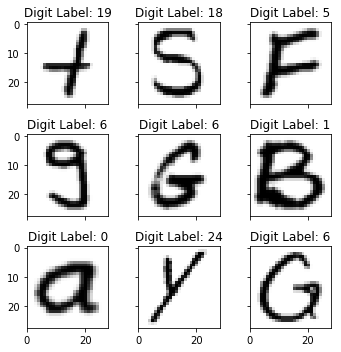

In [5]:
images_to_plot = 9
random_indices = np.random.choice(range(104000), images_to_plot)

sample_images = data["x_train_flat"][random_indices, :]
sample_labels = data["y_train"][random_indices]

plt.clf()
plt.style.use("seaborn-muted")

fig, axes = plt.subplots(3, 3, 
                         figsize=(5,5),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect="equal"))

for i in range(images_to_plot):
    
    subplot_row = i // 3 
    subplot_col = i % 3  
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i, :], (28, 28))
    ax.imshow(plottable_image, cmap="gray_r")
    
    ax.set_title("Digit Label: {}".format(sample_labels[i]))
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()

Thus, in summary, our training data (**"x_train"**) consists of 104000 28x28 images of upper- and lowercase letters, with the labels saying what letter the image depicts (**"y_train"**). We also have a flattend version of the images (**"x_train_flat"**) and one-hot encoded labels (**"y_train_one_hot"**). This is the same for our validation and test data, both consisting of 20800 examples.

# Stage 1: Train the VAE

Start off by initialising the VAE model:

In [6]:
# Create VAE
vae = VariationalAutoEncoder(
    name = "vae_emnist_letter",
    num_inputs = n_features,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Size of latent dimension
    latent_dim = 20,
    # Specify the encoder layers [units, activation, dropout, l2, bias]
    encoder_layers = [
        [512, "relu", 0.0, 0.0, True, "gaussian"],
        [256, "relu", 0.0, 0.0, True, "gaussian"],
        [128, "relu", 0.0, 0.0, True, "gaussian"]
    ],
    # Specify the decoder layers [units, activation, dropout, l2, bias]
    decoder_layers = [
        [128, "relu", 0.0, 0.0, True, "gaussian"],
        [256, "relu", 0.0, 0.0, True, "gaussian"],
        [512, "relu", 0.0, 0.0, True, "gaussian"]
    ],
    # The final output layer's activation function
    final_activation = "sigmoid",
    # The maximum number of epochs to run
    epochs = 100,
    # The batch size to use in the VAE
    batch_size = 128,
    # The learning rate used in optimisation
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

Next, we train our model. By setting `load_model=True`, we load a previously trained model. If you want to train the VAE model from scratch, set `load_model=False`. The VAE does not receive any target data, seeing as it is not trying to predict the labels, but rather trying to reconstruct its input. Thus, we only pass the flattened training and validation data to the model.

In [7]:
# Train VAE
vae.train(data["x_train_flat"], data["x_valid_flat"], load_model=True)

Loaded vae_emnist_letter model from disk


In [8]:
# Evaluate VAE
vae_results = vae.evaluate(data["x_test_flat"])

accuracy: Nan | loss: 157.2493401512733


With our trained VAE model, we can generate new data. Here, we generate 30000 additional data points:

In [9]:
# Generate new data
x_gen_flat = vae.sample(30000)
print(np.shape(x_gen_flat))

(30000, 784)


Lets visualise some results from our VAE model and the generated data:

<Figure size 432x288 with 0 Axes>

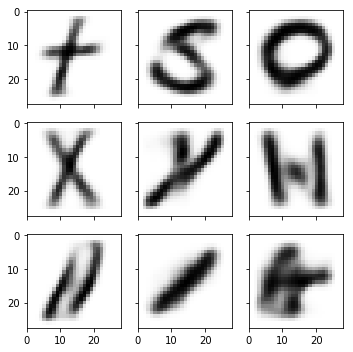

In [17]:
# Reshape to images
x_gen = np.array([np.reshape(x_gen_flat[i], [n_rows, n_cols]) for i in range(len(x_gen_flat))])

images_to_plot = 9
random_indices = np.random.choice(range(30000), images_to_plot)

sample_images = x_gen[random_indices, :]

plt.clf()
plt.style.use("seaborn-muted")

fig, axes = plt.subplots(3, 3, 
                         figsize=(5,5),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect="equal"))

for i in range(images_to_plot):
    
    subplot_row = i // 3 
    subplot_col = i % 3  
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i, :], (28, 28))
    ax.imshow(plottable_image, cmap="gray_r")
    
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()

Here we can see some of the generated images from our VAE model. They are still unlabelled.

# Stage 2: Train the MLP and CNN

Start off by initialising the MLP model:

In [18]:
# Create MLP
mlp = MultiLayerPerceptron(
    name = "mlp_emnist_letter",
    num_inputs = n_features,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # ff_layers = [units, activation, regularization, dropout, use_bias]
    ff_layers = [
        [512, "relu", 0.0, 0.2, True, "gaussian"],
        [512, "relu", 0.0, 0.2, True, "gaussian"],
        [512, "relu", 0.0, 0.2, True, "gaussian"],
        [512, "relu", 0.0, 0.2, True, "gaussian"]
    ],
    # The final output layer's activation function
    final_activation = "softmax",
    # The objective function for the NN
    objective = "categorical_crossentropy",
    # The maximum number of epochs to run
    epochs = 40,
    # The batch size to use in the NN
    batch_size = 64,
    # The learning rate used in optimization
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 10
)

The same format as with the VAE applies, except here we provide the model with the necessary targets:

In [19]:
# Train MLP
mlp.train(
    data["x_train_flat"], data["y_train_one_hot"],
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Loaded mlp_emnist_letter model from disk


In [20]:
# Evaluate MLP
mlp_results = mlp.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 91.44% | loss: 0.33771701676856675


The MLP model achieved an accuracy of 91.44% on the test set. Next, we do the same for the CNN model:

In [21]:
# Create CNN
cnn = ConvDNN(
    name = "cnn_emnist_letter",
    img_rows = n_rows,
    img_cols = n_cols,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Convolutional layers
    conv_layers = [
        ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.2],
        ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.2],
        ["max_pool2d", (2, 2), None, "valid", 0.0],
        ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.2],
        ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.2],
        ["max_pool2d", (2, 2), None, "valid", 0.0],
    ],
    # ff_layers = [units, activation, regularization, dropout, use_bias]
    ff_layers = [
        [512, "relu", 0.0, 0.2, True, "normal"],
        [512, "relu", 0.0, 0.2, True, "normal"]
    ],
    # The final output layer's activation function
    final_activation = "softmax",
    # The objective function for the NN
    objective = "categorical_crossentropy",
    # The maximum number of epochs to run
    epochs = 20,
    # The batch size to use in the NN
    batch_size = 128,
    # The learning rate used in optimization
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

For the CNN model, we do not use the flattened training data:

In [22]:
# Train CNN
cnn.train(
    data["x_train"], data["y_train_one_hot"],
    data["x_valid"], data["y_valid_one_hot"], load_model=True)

Loaded cnn_emnist_letter model from disk


In [23]:
# Evaluate CNN
cnn_results = cnn.evaluate(data["x_test"], data["y_test_one_hot"])

accuracy: 94.35% | loss: 0.16695101275753516


The CNN model outperformed the standard MLP model, achieving an accuracy of 94.35% on the test set.

# Stage 3: Produce soft targets for our interpretable model

We will now use our trained CNN model to:
1. Relabel our original training data, **x_train**
2. Give labels to our unlabelled, generated data, **x_gen**

In [24]:
# Get CNN labels
y_cnn_train = cnn.predict(data["x_train"])
y_gen = cnn.predict(x_gen)

Now we combine both the original training data and the generated data, as well as their new soft target labels, and shuffle them:

In [25]:
# Combine x_train and x_gen
x_both = join_data([data["x_train"], x_gen])

# Flatten them to use it with our interpretable model
x_both = x_both.reshape((x_both.shape[0], -1))

# Combine y_cnn_train and y_gen
y_both = join_data([y_cnn_train, y_gen])

# Shuffle the data
x_both, y_both = shuffle(x_both, y_both)

print("x_both ==>", np.shape(x_both))
print("y_both ==>", np.shape(y_both))

x_both ==> (134000, 784)
y_both ==> (134000, 26)


Thus, we have increased our training data from 104000 samples to 134000, where each sample now has a soft target produced by the CNN model, which we are going to approximate.

# Stage 4: Train our interpretable model, the SDT

For the sake of comparison, we will train three separate models:
1. SDT using only the original data with original hard targets.
2. SDT using only the original data with new soft targets (provided by the CNN in the third stage).
3. SDT using the generated and the original data with soft targets.

## 1) SDT using only the original data with original hard targets

In [26]:
# Create SDT
sdt_raw = SoftBinaryDecisionTree(
    name = "sdt_raw_emnist_letter",
    num_inputs = n_features,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Hyperparameters
    max_depth = 6,
    penalty_strength = 1e+1,
    penalty_decay = 0.5,
    inv_temp = 0.01,
    ema_win_size = 1000,
    # The learning rate used in optimization
    learning_rate = 1e-03,
    epochs = 40,
    batch_size = 4,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 5
)

Hyperparameters:
- `max_depth`: the maximum depth of the tree in terms of its inner nodes. This excludes leaves.
- `penalty_strength`: regularisation penalty strength.
- `penalty_decay`: regularisation penalty decay as a function of depth.
- `inv_temp`: scale the logits of the inner nodes to avoid very soft decisions.
- `ema_win_size`: scaling factor to the default size of the window used to calculate moving averages (growing exponentially with depth) of node and path probabilities.
- `batch_size`: we use a small one, because with increasing depth and thus a large amount of leaf bigots, larger batch sizes cause their loss terms to be scaled down too much by averaging, which results in poor optimisation properties. 

In [27]:
# Train SDT RAW
sdt_raw.train(
    data["x_train_flat"], data["y_train_one_hot"],
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Built tree has 64 leaves out of 127 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_raw_emnist_letter/sdt_raw_emnist_letter
Loaded sdt_raw_emnist_letter model from disk


In [28]:
# Evaluate SDT RAW
sdt_raw_results = sdt_raw.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 62.89% | loss: 53.74929987687331


The test accuracy of our SDT model trained on the original data and labels is 62.89%.

## 2) SDT using only the original data with new soft targets (provided by the CNN in the third stage)

In [29]:
# Create SDT CNN
sdt_cnn = SoftBinaryDecisionTree(
    name = "sdt_cnn_emnist_letter",
    num_inputs = n_features,
    num_outputs = n_classes,
    max_depth = 6,
    penalty_strength = 1e+1,
    penalty_decay = 0.5,
    inv_temp = 0.01,
    ema_win_size = 1000,
    # The learning rate used in optimization
    learning_rate = 1e-03,
    epochs = 40,
    batch_size = 4,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 5
)

We now train this model with the soft targets from the CNN, but still use the hard targets in validation and testing.

In [30]:
# Train SDT CNN
sdt_cnn.train(
    data["x_train_flat"], y_cnn_train,
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Built tree has 64 leaves out of 127 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_cnn_emnist_letter/sdt_cnn_emnist_letter
Loaded sdt_cnn_emnist_letter model from disk


In [31]:
# Evaluate SDT CNN
sdt_cnn_results = sdt_cnn.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 59.70% | loss: 57.76407076395475


By using the soft targets, we did not manage to increase upon the accuracy of our SDT model trained on the hard labels. This can be attributed to the complex model (CNN) misclassifying the data almost 6% of the time, providing incorrect labels to the data. It should be noted that that we set the maximum number of epochs to 40 for all SDT models. With the other two datasets (MNIST and Fashion-MNIST), the early stopping callback mechanism stopped the models before the the 40 epochs were reached, since the validation loss and accuracy became stagnant. On the EMNIST-Letter dataset, the SDT models kept on improving, albeit slowly, but stopped training after 40 epochs. With a depth of 6, the visualisations became unfeasible to plot. 

## 3) SDT using the generated and the original data with soft targets

In [32]:
# Create SDT VAE
sdt_vae = SoftBinaryDecisionTree(
    name = "sdt_cnn_vae_emnist_letter",
    num_inputs = n_features,
    num_outputs = n_classes,
    max_depth = 6,
    penalty_strength = 1e+1,
    penalty_decay = 0.5,
    inv_temp = 0.01,
    ema_win_size = 1000,
    # The learning rate used in optimization
    learning_rate = 1e-03,
    epochs = 40,
    batch_size = 4,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 5
)

In [33]:
# Train SDT VAE
sdt_vae.train(
    x_both, y_both,
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Built tree has 64 leaves out of 127 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_cnn_vae_emnist_letter/sdt_cnn_vae_emnist_letter
Loaded sdt_cnn_vae_emnist_letter model from disk


In [34]:
# Evaluate SDT VAE
sdt_vae_results = sdt_vae.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 62.31% | loss: 57.72686874903165


Interestingly, the SDT with the generated data and soft labels performed better than the SDT with only soft labels. With longer training time, it might have even outperformed the other SDT models.

Now, we conduct another experiment, where we significantly downsample the original data to mimic a scenario where one does not have enough data at one's disposal.

# Downsampling of the data

In [35]:
# Downsample the data
x_train_flat_ds, y_train_ds, indices = balanced_sample_maker(data["x_train_flat"], data["y_train"], 10000,
                                                             random_seed=1234)

x_valid_flat_ds, y_valid_ds, indices = balanced_sample_maker(data["x_valid_flat"], data["y_valid"], 5000,
                                                             random_seed=1234)

x_test_flat_ds, y_test_ds, indices = balanced_sample_maker(data["x_test_flat"], data["y_test"], 5000,
                                                           random_seed=1234)

# Create other data
x_train_ds = x_train_flat_ds.reshape((x_train_flat_ds.shape[0], n_rows, n_cols))
y_train_one_hot_ds = tf.keras.utils.to_categorical(y_train_ds, n_classes)

x_valid_ds = x_valid_flat_ds.reshape((x_valid_flat_ds.shape[0], n_rows, n_cols))
y_valid_one_hot_ds = tf.keras.utils.to_categorical(y_valid_ds, n_classes)

x_test_ds = x_test_flat_ds.reshape((x_test_flat_ds.shape[0], n_rows, n_cols))
y_test_one_hot_ds = tf.keras.utils.to_categorical(y_test_ds, n_classes)

# Print shapes
print("y_train_one_hot_ds", " ==>", np.shape(y_train_one_hot_ds))
print("x_test_flat_ds", " ==>", np.shape(x_test_flat_ds))
print("x_train_ds", " ==>", np.shape(x_train_ds))
print("x_test_ds", " ==>", np.shape(x_test_ds))
print("y_train_ds", " ==>", np.shape(y_train_ds))
print("y_test_one_hot_ds", " ==>", np.shape(y_test_one_hot_ds))
print("y_test_ds", " ==>", np.shape(y_test_ds))
print("x_valid_ds", " ==>", np.shape(x_valid_ds))
print("y_valid_ds", " ==>", np.shape(y_valid_ds))
print("y_valid_one_hot_ds", " ==>", np.shape(y_valid_one_hot_ds))
print("x_valid_flat_ds", " ==>", np.shape(x_valid_flat_ds))
print("x_train_flat_ds", " ==>", np.shape(x_train_flat_ds))

y_train_one_hot_ds  ==> (9984, 26)
x_test_flat_ds  ==> (4992, 784)
x_train_ds  ==> (9984, 28, 28)
x_test_ds  ==> (4992, 28, 28)
y_train_ds  ==> (9984,)
y_test_one_hot_ds  ==> (4992, 26)
y_test_ds  ==> (4992,)
x_valid_ds  ==> (4992, 28, 28)
y_valid_ds  ==> (4992,)
y_valid_one_hot_ds  ==> (4992, 26)
x_valid_flat_ds  ==> (4992, 784)
x_train_flat_ds  ==> (9984, 784)


Thus, we have created new data variables, each appended with "ds". We will now use these variables and repeat the _vitrify_ process.

# Stage 1: Train the VAE

Again we start off by initialising the VAE model. Note the name change.

In [36]:
# Clear our current Keras session
K.clear_session()

# Create VAE
vae = VariationalAutoEncoder(
    name = "vae_emnist_letter_ds",
    num_inputs = n_features,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Size of latent dimension
    latent_dim = 20,
    # Specify the encoder layers [units, activation, dropout, l2, bias]
    encoder_layers = [
        [512, "relu", 0.0, 0.0, True, "gaussian"],
        [256, "relu", 0.0, 0.0, True, "gaussian"],
        [128, "relu", 0.0, 0.0, True, "gaussian"]
    ],
    # Specify the decoder layers [units, activation, dropout, l2, bias]
    decoder_layers = [
        [128, "relu", 0.0, 0.0, True, "gaussian"],
        [256, "relu", 0.0, 0.0, True, "gaussian"],
        [512, "relu", 0.0, 0.0, True, "gaussian"]
    ],
    # The final output layer's activation function
    final_activation = "sigmoid",
    # The maximum number of epochs to run
    epochs = 100,
    # The batch size to use in the VAE
    batch_size = 128,
    # The learning rate used in optimisation
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

In [37]:
# Train VAE
vae.train(x_train_flat_ds, x_valid_flat_ds, load_model=True)

Loaded vae_emnist_letter_ds model from disk


In [38]:
# Evaluate VAE
vae_results = vae.evaluate(x_test_flat_ds)

accuracy: Nan | loss: 169.49714709550906


With our trained VAE model, we can generate new data. Here we generate 40000 additional data points:

In [39]:
# Generate new data
x_gen_flat = vae.sample(40000)
print(np.shape(x_gen_flat))

(40000, 784)


In [40]:
# Reshape to images
x_gen = np.array([np.reshape(x_gen_flat[i], [n_rows, n_cols]) for i in range(len(x_gen_flat))])
print(np.shape(x_gen))

(40000, 28, 28)


# Stage 2: Train the CNN

In [41]:
# Create CNN
cnn = ConvDNN(
    name = "cnn_emnist_letter_ds",
    img_rows = n_rows,
    img_cols = n_cols,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Convolutional layers
    conv_layers = [
        # Layer, filters, kernel size, strides, padding, activation, use bias, kernel reg, bias reg, activity reg,
        # dropout (after layers)
            ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.2],
            ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.2],
            ["max_pool2d", (2, 2), None, "valid", 0.0],
            ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.2],
            ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.2],
            ["max_pool2d", (2, 2), None, "valid", 0.0]
    ],
    # ff_layers = [units, activation, regularization, dropout, use_bias]
    ff_layers = [
        [512, "relu", 0.0, 0.2, True, "normal"],
        [512, "relu", 0.0, 0.2, True, "normal"]
    ],
    # The final output layer's activation function
    final_activation = "softmax",
    # The objective function for the NN
    objective = "categorical_crossentropy",
    # The maximum number of epochs to run
    epochs = 20,
    # The batch size to use in the NN
    batch_size = 128,
    # The learning rate used in optimization
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

For the CNN model, we do not use the flattenend training data:

In [42]:
# Train CNN
cnn.train(
    x_train_ds, y_train_one_hot_ds,
    x_valid_ds, y_valid_one_hot_ds, load_model=True)

Loaded cnn_emnist_letter_ds model from disk


In [43]:
# Evaluate CNN
cnn_results = cnn.evaluate(x_test_ds, y_test_one_hot_ds)

accuracy: 91.59% | loss: 0.28389772256979573


# Stage 3: Produce soft targets for our interpretable model

We will now use our trained CNN model to:
1. Relabel our original training data, **x_train_ds**
2. Give labels to our unlabelled, generated data, **x_gen**

In [44]:
# Get CNN labels
y_cnn_train = cnn.predict(x_train_ds)
y_gen = cnn.predict(x_gen)

Now we combine both the original training data and the generated data, as well as their new soft target labels, and shuffle them:

In [45]:
# Combine x_train and x_gen
x_both = join_data([x_train_ds, x_gen])

# Flatten them to use it with our interpretable model
x_both = x_both.reshape((x_both.shape[0], -1))

# Combine y_cnn_train and y_gen
y_both = join_data([y_cnn_train, y_gen])

# Shuffle the data
x_both, y_both = shuffle(x_both, y_both)

print("x_both ==>", np.shape(x_both))
print("y_both ==>", np.shape(y_both))

x_both ==> (49984, 784)
y_both ==> (49984, 26)


Thus, we have increased our training data to 49984, where each sample now has a soft target produced from the CNN model, which we are going to approximate.

# Stage 4: Train our interpretable model, the SDT

## 1) SDT using only the original data with original hard targets

In [46]:
# Create SDT
sdt_raw = SoftBinaryDecisionTree(
    name = "sdt_raw_emnist_letter_ds",
    num_inputs = n_features,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Hyperparameters
    max_depth = 5,
    penalty_strength = 1e+1,
    penalty_decay = 0.5,
    inv_temp = 0.01,
    ema_win_size = 1000,
    # The learning rate used in optimization
    learning_rate = 1e-03,
    epochs = 40,
    batch_size = 4,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 5
)

In [47]:
# Train SDT RAW
sdt_raw.train(
    x_train_flat_ds, y_train_one_hot_ds,
    x_valid_flat_ds, y_valid_one_hot_ds, load_model=True)

Built tree has 32 leaves out of 63 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_raw_emnist_letter_ds/sdt_raw_emnist_letter_ds
Loaded sdt_raw_emnist_letter_ds model from disk


In [48]:
# Evaluate SDT RAW
sdt_raw_results = sdt_raw.evaluate(x_test_flat_ds, y_test_one_hot_ds)

accuracy: 31.15% | loss: 40.83087239815639


## 2) SDT using only the original data with new soft targets (provided by the CNN in the third stage)

In [49]:
# Create SDT CNN
sdt_cnn = SoftBinaryDecisionTree(
    name = "sdt_cnn_emnist_letter_ds",
    num_inputs = n_features,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Hyperparameters
    max_depth = 5,
    penalty_strength = 1e+1,
    penalty_decay = 0.5,
    inv_temp = 0.01,
    ema_win_size = 1000,
    # The learning rate used in optimization
    learning_rate = 1e-03,
    epochs = 40,
    batch_size = 4,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 5
)

In [50]:
# Train SDT CNN
sdt_cnn.train(
    x_train_flat_ds, y_cnn_train,
    x_valid_flat_ds, y_valid_one_hot_ds, load_model=True)

Built tree has 32 leaves out of 63 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_cnn_emnist_letter_ds/sdt_cnn_emnist_letter_ds
Loaded sdt_cnn_emnist_letter_ds model from disk


In [51]:
# Evaluate SDT CNN
sdt_cnn_results = sdt_cnn.evaluate(x_test_flat_ds, y_test_one_hot_ds)

accuracy: 28.85% | loss: 36.14033850645408


## 3) SDT using the generated and the original data with soft targets

In [52]:
# Create SDT VAE
sdt_vae = SoftBinaryDecisionTree(
    name = "sdt_cnn_vae_emnist_letter_ds",
    num_inputs = n_features,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Hyperparameters
    max_depth = 5,
    penalty_strength = 1e+1,
    penalty_decay = 0.5,
    inv_temp = 0.01,
    ema_win_size = 1000,
    # The learning rate used in optimization
    learning_rate = 1e-03,
    epochs = 40,
    batch_size = 4,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 5
)

In [53]:
# Train SDT VAE
sdt_vae.train(
    x_both, y_both,
    x_valid_flat_ds, y_valid_one_hot_ds, load_model=True)

Built tree has 32 leaves out of 63 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_cnn_vae_emnist_letter_ds/sdt_cnn_vae_emnist_letter_ds
Loaded sdt_cnn_vae_emnist_letter_ds model from disk


In [54]:
# Evaluate SDT VAE
sdt_vae_results = sdt_vae.evaluate(x_test_flat_ds, y_test_one_hot_ds)

accuracy: 48.32% | loss: 35.659014814939255


This classification problem was too complex for our SDT models to adequately capture the underlying phenomenon. We do see, however, that the addition of generated data and soft labels did help the SDT model. In terms of inter- pretability, it was clear that the SDT models struggle to distinguish between classes, with the added difficulty of classifying upper- and lowercase letters simultaneously. With a depth of 6, the visualisations became unfeasible to plot. Classifying, for example, an “a” and “A” to the same label (i.e. 0), made the problem too hard for our SDT models. We decided to reduce the problem to only distinguishing among uppercase letters, by removing all the lowercase letters. This can be seen in the *vitrify_emnist_letter_uppercase.ipynb* notebook.